In [1]:
import os
from scipy.signal import detrend
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces2 = cat["ECCO_layers"].to_dask()
ds_faces=xr.merge((ds_faces1,ds_faces2))

/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [3]:
import gcsfs
basins = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-data/ECCO_basins.zarr')
                      , consolidated=True)


In [4]:
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins.basin_mask == 2,0)+ mask_2d.where(basins.basin_mask == 7,0)
              + mask_2d.where(basins.basin_mask == 9,0)
             + mask_2d.where(basins.basin_mask == 10,0)
             + mask_2d.where(basins.basin_mask == 12,0)
             + mask_2d.where(basins.basin_mask == 18,0)
             + mask_2d.where(basins.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))

basins2=basins.rename({'j':'j_g'})
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins2.basin_mask == 2,0)+ mask_2d.where(basins2.basin_mask == 7,0)
              + mask_2d.where(basins2.basin_mask == 9,0)
             + mask_2d.where(basins2.basin_mask == 10,0)
             + mask_2d.where(basins2.basin_mask == 12,0)
             + mask_2d.where(basins2.basin_mask == 18,0)
             + mask_2d.where(basins2.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))

basins3=basins.rename({'i':'i_g'})
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins3.basin_mask == 2,0)+ mask_2d.where(basins3.basin_mask == 7,0)
              + mask_2d.where(basins3.basin_mask == 9,0)
             + mask_2d.where(basins3.basin_mask == 10,0)
             + mask_2d.where(basins3.basin_mask == 12,0)
             + mask_2d.where(basins3.basin_mask == 18,0)
             + mask_2d.where(basins3.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
THETA_jg = grid.interp(ds.THETA, axis = 'Y')

In [11]:
from dask.distributed import Client

client = Client("tcp://10.32.2.153:44257")
client

Client Scheduler: tcp://10.32.2.153:44257 Dashboard: /user/0000-0002-2584-2760/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [12]:
latchoice=219

In [13]:
#Makes array of total volume transport above sigma=102 in the basin as a function of time
tr = (ds.LaVH3RHO[:].chunk({'time':14}).rolling(time=14).mean() * coords.dxG * ds.atl_maskS)[:, :101, latchoice, :].sum('l3_c') #at j_g = 215, up to sigma = 102
volume_over_time = tr.sum('i') 
volume_over_time.load()

<xarray.DataArray (time: 288)>
array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        , 13230828.50440046, 13219264.5929592 ,
       13267803.75246645, 13593909.03744846, 13756327.86436644,
       13857615.88040154, 13910994.46223845, 14015393.32542509,
       14308345.97732586, 14258867.59544931, 14036999.29170717,
       13931879.31595599, 13737810.86264894, 13798224.91206547,
       13646851.93995675, 13592657.28922663, 13852341.03146213,
       13688938.96229922, 13755388.01109312, 13809508.15288235,
       13805039.00730182, 13793635.89837225, 13516023.4565152 ,
       13427513.5592451 , 13354587.15534868, 13727745.69912837,
       14186978.37135148, 14322485.88781986, 14526945.09887307,
       14647744.24832393, 14711419.33606436, 14902052.41746234,
       15057028.63224736, 15241644.92877363, 15347701.28293693,
       15285935.8705792 , 15489731.83168632, 15951001.65106357,
       16394713.94889839, 16624821.48594156, 16597800.95684067,
       16695382.96243853, 16640097.90276669, 16685541.29623242,
       16629210.44871055, 16587672.60856811, 16706501.93352099,
       16692499.94412513, 16241535.18217676, 16478362.33942664,
       16587471.01352356, 16490065.81041384, 16509632.42938467,
       16343622.81881608, 16328347.04625891, 16434983.33294819,
       16554161.4565426 , 16271684.85741083, 16203158.68243501,
       16087945.87031134, 16134402.00353219, 16093832.88151534,
       16295608.96096125, 16379815.39874089, 16245135.80164929,
       16130043.11187385, 16001134.22294503, 15976443.14690612,
       15993350.58155587, 15858619.16124537, 15313463.29531083,
       15403268.08658632, 15497336.53236957, 15735177.41775694,
       15352652.95218798, 15243877.32990562, 15398789.98509381,
       15240585.83597295, 15200007.13286892, 15118466.56500014,
       14895804.91161202, 14972427.93511784, 14827424.53341636,
       14904790.67395448, 15054752.62458408, 15324038.74517862,
       15284300.55224793, 15149614.49718089, 15180472.59766998,
       15199067.72912997, 15212852.68263697, 15236569.61932268,
       15128252.97037782, 15158718.74183406, 14939581.04057648,
       14619389.49020561, 14635089.64214717, 14449267.03556192,
       14575990.70142529, 14513222.00331314, 14567551.83366556,
       14512096.38395163, 14615649.67330245, 14764406.50744911,
       14737423.8920675 , 14976665.66835815, 15493101.99681767,
       15263978.97580543, 15487289.8934489 , 15686757.65198676,
       15690444.50224651, 15569342.30394747, 15540426.59383072,
       15434309.58654879, 15419497.38736499, 15629416.61587435,
       15652651.25301418, 15174144.37082335, 15121749.84123103,
       14742984.90322698, 14093302.6452088 , 14348001.1763024 ,
       14624407.7374081 , 14657746.3120964 , 14700145.17774207,
       14895638.9480084 , 15075485.16914797, 15243745.962041  ,
       15406406.60080096, 15167566.63571364, 15287447.53556133,
       15411785.98569084, 15645412.5749987 , 15714357.48137955,
       16021871.57029107, 16155484.00746671, 16133832.98521662,
       16236775.7842958 , 16289483.64541486, 16337307.64245619,
       16460187.73142505, 16504463.12270109, 16341489.15011744,
       16475250.97381576, 16564464.176149  , 16950127.31494725,
       16827633.42011391, 16995702.26842123, 16998685.90548664,
       16969708.67278553, 16964775.80949613, 16892906.8352171 ,
       16881192.4641108 , 16892189.95241008, 16823566.99858377,
       16550025.23821169, 16430376.24565529, 16403422.67070561,
       16395515.94259777, 16167003.61554399, 16224892.79487099,
       16161023.05263133, 16202731.91418047, 16070475.54595464,
       16078682.77448286, 16096562.2281365 , 15803428.8034476 ,
       15621081.52472955, 15112437.90565941, 15042461.97480447,
       15136720.02792375, 14954171.47300708, 14642537.89040561,
 

In [14]:
tr = (ds.LaVH3RHO * coords.dxG * ds.atl_maskS)[:, :101, latchoice, :].sum('l3_c').chunk({'time':24}).rolling(time=12).mean()
volume_over_time = tr.sum('i') 
volume_over_time.load()

<xarray.DataArray (time: 288)>
array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        , 12998965.85385641,
       12787711.86903572, 13240064.72859978, 13541663.04876224,
       13563217.05626416, 13762381.67247527, 13705867.9331615 ,
       13919645.19923754, 14129996.11151438, 14104486.99009584,
       14228450.82799649, 14422610.64912305, 14396620.64986291,
       14151251.94351652, 13590445.27181297, 13463165.5746597 ,
       13682287.61400514, 13540202.67583678, 13675232.41787579,
       13565591.93468923, 13524327.07349196, 13679445.831271  ,
       13542804.64648634, 13561716.67683927, 13620645.68693919,
       13834183.93296036, 13949526.32467927, 14069026.19508991,
       14220592.77510681, 14314632.27301846, 14469325.69265124,
       14658808.84286561, 14790602.2970089 , 14840226.91003256,
       14984981.63592842, 15368789.70007262, 15679762.11064502,
       15729876.04006238, 16111647.80933311, 16427982.54355142,
       16525217.83181734, 16755084.39289856, 16636591.27606901,
       16703544.10615215, 16719450.68713729, 16739545.86809737,
       16624814.41621595, 16410592.53645944, 16570249.06160982,
       17009781.11920953, 16556866.01955053, 16345130.17648596,
       16336531.0513958 , 16270767.58876909, 16422354.54978535,
       16344697.55867237, 16272881.94347661, 16411226.48232055,
       16631893.52960801, 16370893.49174722, 16037580.62328232,
       15705279.45034336, 16445260.35319115, 16561163.41831302,
       16216360.29156118, 16216504.69620085, 16027951.65237119,
       16021591.26400316, 16040606.25591916, 15809734.00828994,
       15618602.58932542, 15929316.50346085, 15593915.57796314,
       15572102.74406804, 15294337.5735926 , 15286848.07595856,
       15345145.00962232, 15235902.3380052 , 15228956.83891311,
       15178804.54098313, 15093303.38061572, 15020618.58511286,
       14760136.30765133, 14775844.24447448, 15051557.36711521,
       15347759.52205703, 15077567.68554674, 15092440.95939333,
       15214593.10699587, 15176874.77111305, 15090441.39096119,
       15187464.54668839, 15243943.3136425 , 15316591.43769276,
       15364492.78250915, 15237957.85961512, 14890985.5660048 ,
       14442876.19676746, 14561950.55427216, 14327192.52750421,
       14251206.19292032, 14349983.04988095, 14499518.88232405,
       14375408.20173832, 14393704.54673757, 14636607.5828359 ,
       14787976.05561379, 15104196.18530419, 16010267.23145721,
       15989978.92614826, 15885219.19252349, 15886615.2492631 ,
       15862146.65523024, 15559332.87824427, 15386226.74644635,
       15425898.45291097, 15437341.21539703, 15384586.66156775,
       15461469.80117537, 14866999.40237863, 14354731.87409604,
       14496369.76729599, 14383948.77517708, 14428096.37118318,
       14641509.63354534, 14823086.59210353, 14881818.33646015,
       14930883.79994714, 14984879.15852648, 14975949.35677206,
       15150055.78781494, 15376912.63727309, 15654783.77789405,
       15647267.33191981, 16165526.79218426, 16090452.12321933,
       16014323.24687388, 16175457.01578186, 16314145.40893232,
       16387746.23443883, 16298149.89210485, 16206705.76043152,
       16214290.47758792, 16535661.92492409, 16379771.00479708,
       16617621.79008549, 16727010.64590274, 17088998.80441546,
       17105582.28364424, 17070706.76099961, 17023318.32052223,
       17030545.38568655, 17101986.26702714, 17035945.2926599 ,
       16789322.08023821, 16659053.72842534, 16776714.63413197,
       16622898.56671934, 16223335.08588775, 15979799.70513691,
       16222873.58880057, 16122183.70939201, 16202823.65459266,
       16127240.20415303, 16134267.10932063, 16071042.21488035,
       16165724.96246121, 16107712.94767406, 15599160.85257935,
       15575286.06269619, 15239119.90413678, 15035111.08816802,
       14754739.8521014 , 14564828.87217719, 14376792.86692429,
 

In [15]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:300] - volume_over_time 
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1) #largest, time dimension
istar1 = istar_over_time + 110
volume_over_i.load()

<xarray.DataArray (time: 288, i: 190)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.49940887e+07, -1.49940887e+07, -1.49940887e+07, ...,
        -1.86264515e-09, -1.86264515e-09, -1.86264515e-09],
       [-1.52685249e+07, -1.52685249e+07, -1.52685249e+07, ...,
        -3.72529030e-09, -3.72529030e-09, -3.72529030e-09],
       [-1.50276381e+07, -1.50276381e+07, -1.50276381e+07, ...,
        -1.86264515e-09, -1.86264515e-09, -1.86264515e-09]])
Coordinates:
  * i        (i) int64 110 111 112 113 114 115 116 ... 294 295 296 297 298 299
    j_g      int64 219
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

In [17]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
l_i = grid.interp(coords.XC, axis = 'Y')
long_interp = l_i[220, :]
istar2 = long_interp[istar1]
istar2.load()

<xarray.DataArray 'mul-32d96ce100fe1d4819cef75830d927aa' (time: 288)>
array([-107.5, -107.5, -107.5, -107.5, -107.5, -107.5, -107.5, -107.5,
       -107.5, -107.5, -107.5,  -30.5,  -31.5,  -31.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -31.5,  -30.5,  -31.5,  -30.5,  -30.5,  -30.5,
        -31.5,  -31.5,  -32.5,  -32.5,  -32.5,  -32.5,  -41.5,  -42.5,
        -42.5,  -43.5,  -43.5,  -43.5,  -42.5,  -42.5,  -42.5,  -42.5,
        -41.5,  -41.5,  -31.5,  -31.5,  -31.5,  -31.5,  -31.5,  -30.5,
        -30.5,  -29.5,  -29.5,  -29.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -27.5,  -27.5,  -28.5,  -27.5,  -27.5,  -27.5,  -27.5,  -27.5,
        -27.5,  -27.5,  -27.5,  -27.5,  -27.5,  -27.5,  -26.5,  -26.5,
        -27.5,  -25.5,   -8.5,  -25.5,  -25.5,  -26.5,  -25.5,  -25.5,
        -26.5,  -27.5,  -27.5,  -28.5,  -28.5,  -29.5,  -29.5,  -29.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -31.5,  -31.5,  -31.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -29.5,  -29.5,  -29.5,  -29.5,  -28.5,  -28.5,  -27.5,
        -27.5,  -27.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -27.5,
        -26.5,  -25.5,  -24.5,  -23.5,  -23.5,  -23.5,  -23.5,  -23.5,
        -23.5,  -22.5,  -23.5,  -24.5,  -25.5,  -25.5,  -26.5,  -26.5,
        -27.5,  -27.5,  -27.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -28.5,  -28.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -30.5,  -30.5,  -30.5,  -30.5,  -31.5,  -31.5,  -31.5,
        -32.5,  -31.5,  -31.5,  -31.5,  -41.5,  -31.5,  -42.5,  -30.5,
        -30.5,  -29.5,  -29.5,  -28.5,  -28.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -27.5,  -27.5,  -27.5,  -28.5,  -28.5,  -28.5,
        -28.5,  -28.5,  -28.5,  -28.5,  -28.5,  -29.5,  -28.5,  -29.5,
        -30.5,  -29.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,
        -30.5,  -29.5,  -30.5,  -30.5,  -30.5,  -30.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -30.5,  -30.5,  -29.5,  -29.5,  -29.5,
        -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -29.5,  -30.5,
        -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5,  -30.5],
      dtype=float32)
Coordinates:
    j_g      int64 220
    i        (time) int64 110 110 110 110 110 110 ... 187 187 187 187 187 187
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

In [18]:
istar3 = istar1+1 
volume_at_istar = tr.where(tr.i < istar1).sum('i')

#Interpolation
nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 

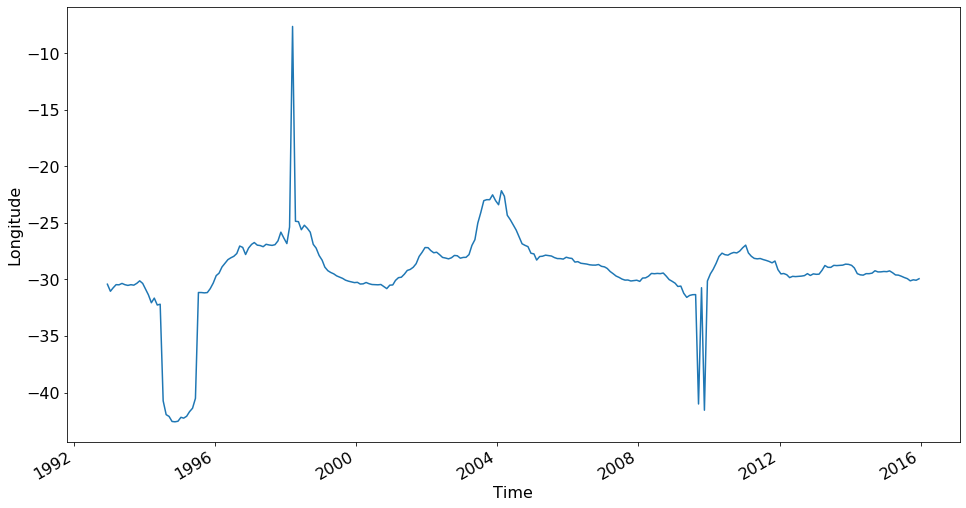

In [21]:
smooth_longitude =  ratio + istar2
smooth_longitude.plot(figsize=(16,8))
pltt.ylabel("Longitude")
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
